## Task 3: Analyse sea ice extent over a region

In this task you will learn how to interpret and analyse Sea Ice Extent (SIE) data for the Arctic and Antarctic regions. Over the course of this task you will:

* Learn how to compare SIE data for a given year to the climatic median and other percentiles.
* Learn how to smooth climatology data to aid analysis.
* Learn how to perform regression analysis on subsets of data, such as finding monthly trends over multiple years.

This task is based in python. While you don't need to understand python to follow the course, you need to know how to install python packages, and how to use a Jupyter notebook to run given python code. Some optional exercises will require modification of certain parameters in given code, and guidance will be provided in those cases. [link to python help]

This task is split into four main lessons. Before the first lesson, the getting setup section will help you setup your Jupyter notebook with the required python packages, and then download the data we will require for this task.

#### Getting setup

In [211]:
import xarray as xr
import os
import datetime
import glob
from pydap.client import open_url
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import pandas as pd     
from scipy import stats    

For this task, we will analyse sea ice extent (SIE) using the [EUMETSAT OSI SAF Sea Ice Index](https://osi-saf.eumetsat.int/products/osi-420) dataset. This can be accessed without an account.

*The steps to download data outlined here will become deprecated from March 2024 due to updates to the CMEMS datastore. The course will be updated once the required data can be stably accessed via the python API.*

This first cell creates the directory to store downloaded data, and specifies the data we will work with.

In [739]:
# Create a download directory for sea ice products
download_dir = os.path.join(os.getcwd(), "sea_ice_products")
os.makedirs(download_dir, exist_ok=True)

# Selection of data to download. See https://thredds.met.no/thredds/osisaf/osisaf_seaiceindex.html for all available regions.
freqs = ["daily", "monthly"] # Frequency of recorded data
regions = {"nh": "Arctic", "sh": "Antarctic"} # Northern and Southern hemisphere data. 


Next, we download and save all the selected data.

In [740]:
for freq in freqs:
    for region in regions:
        # Access the data store for the selected region and frequency
        data_store = xr.backends.PydapDataStore(open_url(
            f'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/{region}/osisaf_{region}_sie_{freq}.nc'))
        DS = xr.open_dataset(data_store)

        data_name = f"{DS.product_name} [{DS.version}]"

        # Download and save the sea ice index (SIE) for the selected parameters
        TS = DS.sie 
        TS.to_netcdf(os.path.join(download_dir,f"TS_{region}_{freq}.nc"))

OSError: [Errno 22] Invalid argument: 'c:\\Users\\georg\\OneDrive\\Documents\\IDEMS\\sea_ice_products\\TS_nh_daily.nc'

Finally, we will store all the datasets we work with in a dictionary `sie`. The dataset for a given frequency and region will be stored in a subdictionary of `sie`. For example, the dataset for the northern hemisphere (nh) at a daily frequency will be stored in the subdictionary `sie["daily"]["nh"]`.

The dataset contains readings from 25 October 1978 to the present day. We will work with data for which there are full calendar years recorded, that is from 1979 through to 2023.

In [741]:
# Select years load and store
start_year = 1979
end_year = 2023

# Initialise dictionary
sie = {}
for freq in freqs:
    sie[freq] = {} 

# Load and store data from selected years in dictionary for all regions and frequencies
for freq in freqs:
    for region in regions:
        sie[freq][region] = {}
        DS = xr.open_dataset(os.path.join(download_dir,f"TS_{region}_{freq}.nc")).sel(
            time = slice(f'{start_year}-01-01', f'{end_year + 1}-12-31')
        )
        sie[freq][region]["dataset"] = DS
        sie[freq][region]["start_year"] = start_year
        sie[freq][region]["end_year"] = end_year


#### Lesson 1: Finding the climatic median and percentiles

One goal of this task is to learn how to compare sea ice extent for a given year to a reference period defined over multiple years. One way to do this is to compare the time series to the median, or other percentiles, of the data over the reference period. This is a simple way to create visual and easy-to-understand representations of the data.

We will start by looking at the daily data for the northern hemisphere (Arctic) region. The following cell computes and plots the median sea ice extent for this region for a given day of year, using data taken from a 35-year reference period from 1978 to 2013.

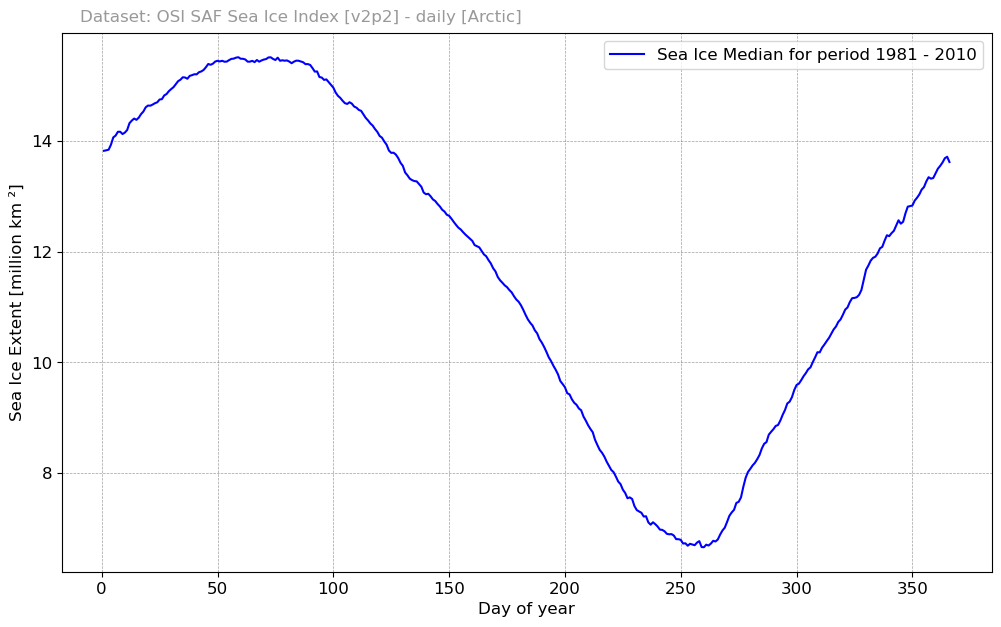

In [749]:
freq = "daily"
region = "nh"

ref_period_start = 1981
ref_period_end = 2010

DS = sie[freq][region]["dataset"].sel(time = slice(f'{ref_period_start}-01-01', f'{ref_period_end}-12-31'))

med = DS.chunk({'time': -1}).groupby('time.dayofyear').quantile(0.5)


plt.figure(figsize=(12,7))

plt.plot(med.dayofyear, med.sie, label = f"Sea Ice Median for period {ref_period_start} - {ref_period_end}", c = "b")

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)

plt.legend()

plt.xlabel("Day of year")
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')

plt.show()


The median calculation reflects noise and short-term fluctuations in the data. When analysing long-term trends or cyclicity in data, noise and short-term fluctuations can obscure conclusions. It is common to apply a smoothing process to time series data in such situations. There are many ways to do this, but one of the more simple is to compute a rolling average of the time series data.

The following cell smooths the median data by applying a rolling averaging process with a window width of 7, and plots the result next to the unsmoothed data. For more information on this implementation of smoothing, see the "Detail on smoothing" section below.

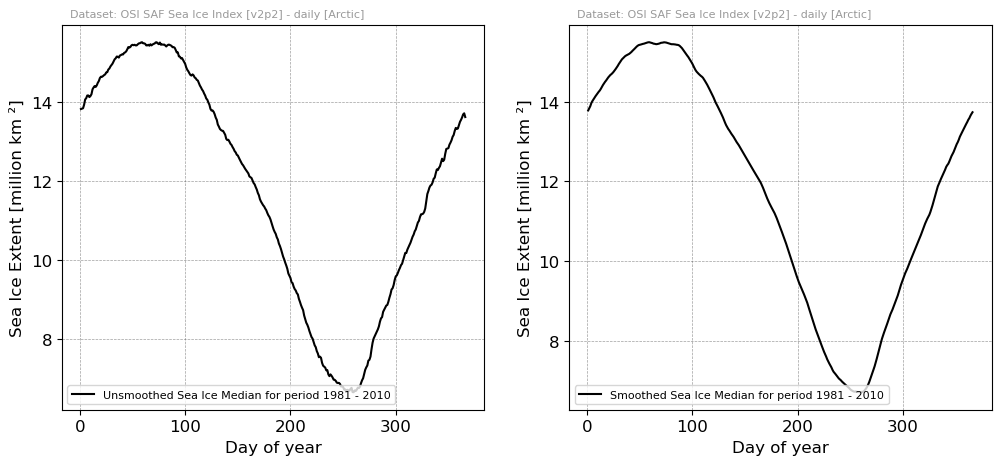

In [750]:
plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1,2)

smoothing_window = 7

med_smooth = (
    med.pad({"dayofyear": (smoothing_window - 1) // 2}, mode="wrap")
    .rolling({"dayofyear": smoothing_window}, center=True)
    .mean()
    .dropna(dim="dayofyear")
)

for i, data, label in zip([0,1], [med, med_smooth], ["Unsmoothed", "Smoothed"]):

    ax = plt.subplot(gs[0,i])

    ax.plot(
        data.dayofyear,
        data.sie,
        label= f"{label}" + f" Sea Ice Median for period {ref_period_start} - {ref_period_end}",
        c="k"
    )

    ax.grid(color="0.25", linestyle="--", linewidth=0.5, alpha=0.5)

    ax.legend(loc = "lower left", fontsize = 8)

    plt.xlabel("Day of year")
    plt.ylabel("Sea Ice Extent [million km \u00b2]")
    ax.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6', fontsize = 8)

plt.show()

The plot demonstrates how we have captured the shape of the data, while removing variation caused by noise and short-term fluctuations.

You can change the `smoothing_window` parameter to change the length of the window over which the rolling average is taken. A smaller value will make the smoothed data follow the fluctuations more closely, while the opposite happens for larger values. When `smoothing_window` is made very large, the seasonal variation in the SIE data starts to be smoothed, and the smoothed median curve tends towards a flat curve.

#### Detail on smoothing

This section goes into more detail on how the smoothing process is implemented in the previous code. The important part of the code is the following (cell should not be run).

In [ ]:
med_smooth = (
    med.pad({"dayofyear": (smoothing_window - 1) // 2}, mode="wrap")
    .rolling({"dayofyear": smoothing_window}, center=True)
    .mean()
    .dropna(dim="dayofyear")
)

A rolling average is taken over a window of width `smoothing_window` centred on a given day of year, which is accomplished by the two functions `.rolling({"dayofyear": smoothing_window}, center=True).mean()`. This works apart from near the start or end of a year, where a window wide enough cannot be defined.

There are multiple ways of dealing with this. We have chosen to apply a padding process to the dataset, which adds values before the start and after the end of the recorded data. The values are chosen according to the `"wrap"` parameter, which chooses the values at the end of the year to add to the front of the dataset, and similarly values at the front of the dataset are added to the end. The number of values we need to add to each end is given by `(smoothing_window - 1) / 2`. This is accomplished by the function `.pad({"dayofyear": (smoothing_window - 1) // 2}, mode="wrap")`.

Once a rolling average is taken on the enlarged dataset, we use the function `.dropna(dim="dayofyear")` to trim the dataset back down to the correct length.

#### Lesson 2: Analysing sea ice extent against a reference period

In this lesson we will develop tools to analyse the sea ice extent for a given year against a reference period. For the purpose of this study, we will use the 30 year reference period of 1981 - 2010. It is also possible to use the more recent WMO-adopted reference period of 1991 - 2020, and we will point out what parameters to alter throughout this lesson. A useful discussion to inform the choice of reference period with particular emphasis on analysing sea ice is provided by the National Snow and Ice Data Center (NSIDC) [here](https://nsidc.org/learn/ask-scientist/why-use-1981-2010-average-sea-ice).

We will compare SIE data for a given year to certain percentiles of reference period data. In the previous lesson we demonstrated a smoothing of the median, the 50th percentile. We supplement this by computing the 25th and 75th percentiles, to form the interquartile range, and the 10th and 90th percentiles, to form the interdecile range.

The following cell performs these calculations for the NH dataset and saves them in a subdictionary of `sie` labelled `"percentiles"`. Each individual percentile is saved in a further subdictionary labelled by its value, for example the 25th percentile is labelled by `"P25"`. If you want to perform the analyses of this lesson with a different reference period, for example 1991 - 2020, then change the parameters `ref_period_start` and `ref_period_end`, accordingly. Please note this cell can take a little while to run!

In [746]:
freq = "daily"
region = "sh"

smoothing_window = 7

ref_period_start = 1981
ref_period_end = 2010

working_dict = sie[freq][region]

working_dict["percentiles"] = {}

for percentile in [0, 10, 25, 50, 75, 90, 100]:
    if percentile in [0,100]:
        dataset = working_dict["dataset"]
    else:
        dataset = working_dict["dataset"].sel(time = slice(f"{ref_period_start}-01-01", f"{ref_period_end}-12-31"))
    working_dict["percentiles"][f"P{percentile}"] = (
        dataset
        .chunk({"time": -1})
        .groupby("time.dayofyear")
        .quantile(percentile / 100)
        .pad({"dayofyear": (smoothing_window - 1) // 2}, mode="wrap")
        .rolling({"dayofyear": smoothing_window}, center=True)
        .mean()
        .dropna(dim="dayofyear")
    )
    working_dict["percentiles"]["ref_period"] = f"{ref_period_start} - {ref_period_end}"   
    working_dict["percentiles"]["total_period"] = f"{start_year} - {end_year}"

Next, let's see how our percentiles look. The following cell plots the maximum, minimum and median lines, while also shading the interquartile and interdecile ranges.

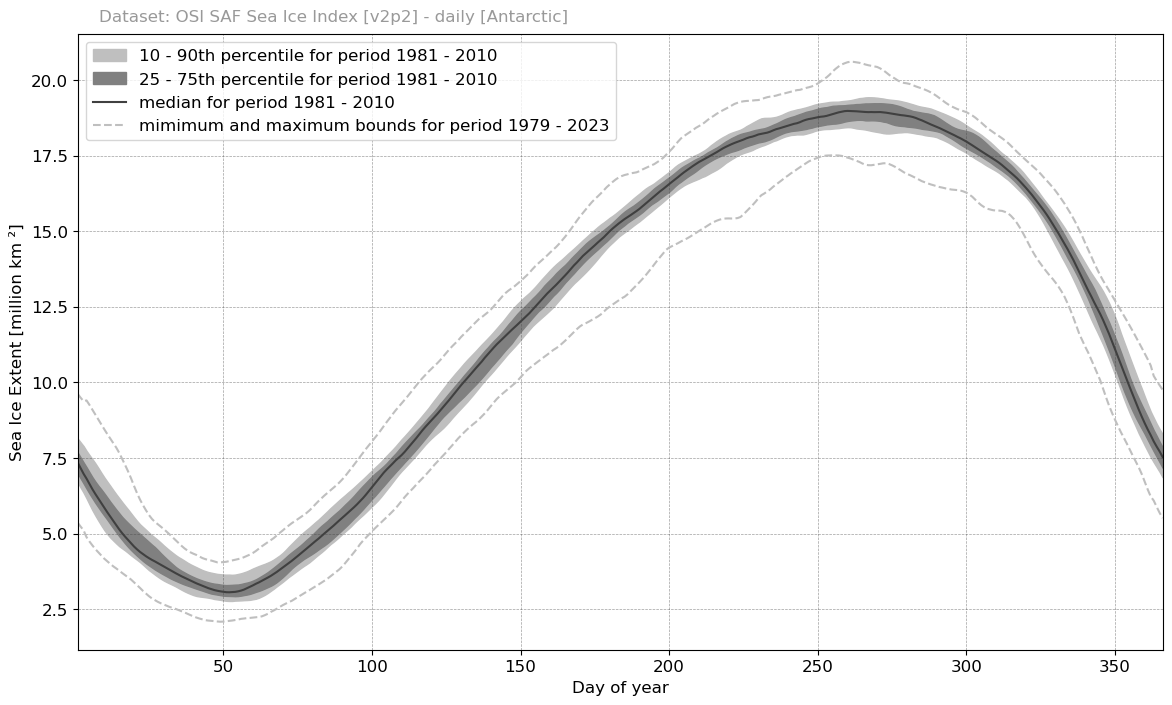

In [748]:
freq = "daily"
region = "sh"

percentiles = sie[freq][region]["percentiles"]

plt.figure(figsize=(14, 8))

plt.fill_between(percentiles['P10'].dayofyear, percentiles['P90'].sie, 
                 percentiles['P10'].sie, color = '0.75', label = f"10 - 90th percentile for period {percentiles['ref_period']}")
plt.fill_between(percentiles['P25'].dayofyear, percentiles['P75'].sie, 
                 percentiles['P25'].sie, color = '0.5', label = f"25 - 75th percentile for period {percentiles['ref_period']}")
plt.plot(percentiles['P50'].dayofyear, percentiles['P50'].sie, c = "0.25", label = f"median for period {percentiles['ref_period']}")

plt.plot(percentiles['P0'].dayofyear, percentiles['P0'].sie, 
         c = "0.75", linestyle='--', label = f"mimimum and maximum bounds for period {percentiles['total_period']}")
plt.plot(percentiles['P100'].dayofyear, percentiles['P100'].sie, c = "0.75", linestyle = '--')

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(ncol = 1)
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.xlabel("Day of year")
plt.xlim(1, 366)
plt.show()

We can now use our percentile plots to visually compare sea ice data for a given year to the reference period. The following cell overlays the most recent year, 2023.

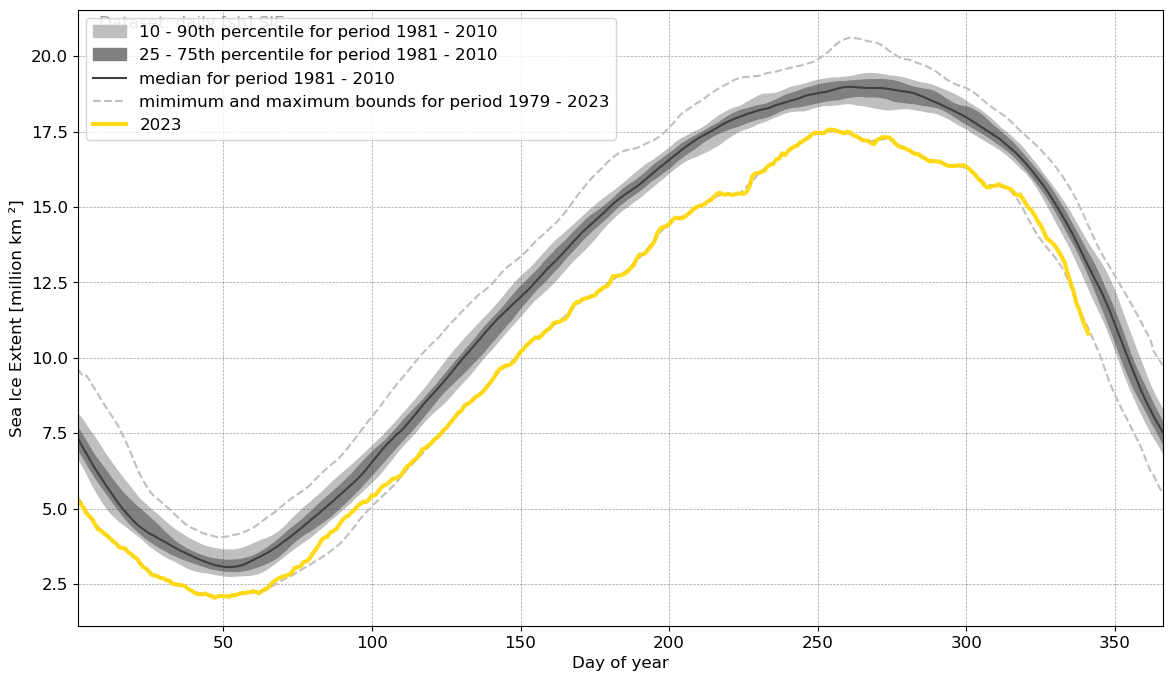

In [378]:
freq = "daily"
region = "sh"

percentiles = sie[freq][region]["percentiles"]

years = [2023]

plt.figure(figsize=(14, 8))

plt.fill_between(percentiles['P10'].dayofyear, percentiles['P90'].sie, 
                 percentiles['P10'].sie, color = '0.75', label = f"10 - 90th percentile for period {percentiles['ref_period']}")
plt.fill_between(percentiles['P25'].dayofyear, percentiles['P75'].sie, 
                 percentiles['P25'].sie, color = '0.5', label = f"25 - 75th percentile for period {percentiles['ref_period']}")
plt.plot(percentiles['P50'].dayofyear, percentiles['P50'].sie, c = "0.25", label = f"median for period {percentiles['ref_period']}")

plt.plot(percentiles['P0'].dayofyear, percentiles['P0'].sie, 
         c = "0.75", linestyle='--', label = f"mimimum and maximum bounds for period {percentiles['total_period']}")
plt.plot(percentiles['P100'].dayofyear, percentiles['P100'].sie, c = "0.75", linestyle = '--')

for year, i in zip(years, range(1,len(years)+1)):
    TS = sie[freq][region]["dataset"].sel(time = slice(f'{year}-01-01', f'{year}-12-31'))
    label = f"{year}"
    plt.plot(TS.time.dt.dayofyear, TS.sie, c = "gold", linewidth = 3, label = label, alpha = 0.9)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(ncol = 1)
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.xlabel("Day of year")
plt.xlim(1, 366)
plt.show()

Alternatively, by altering the `years` list in the cell above, we can get a feel for the evolution of sea ice over time. The following cell plots the data for the years 1982, 1992, 2002, 2012 and 2022.

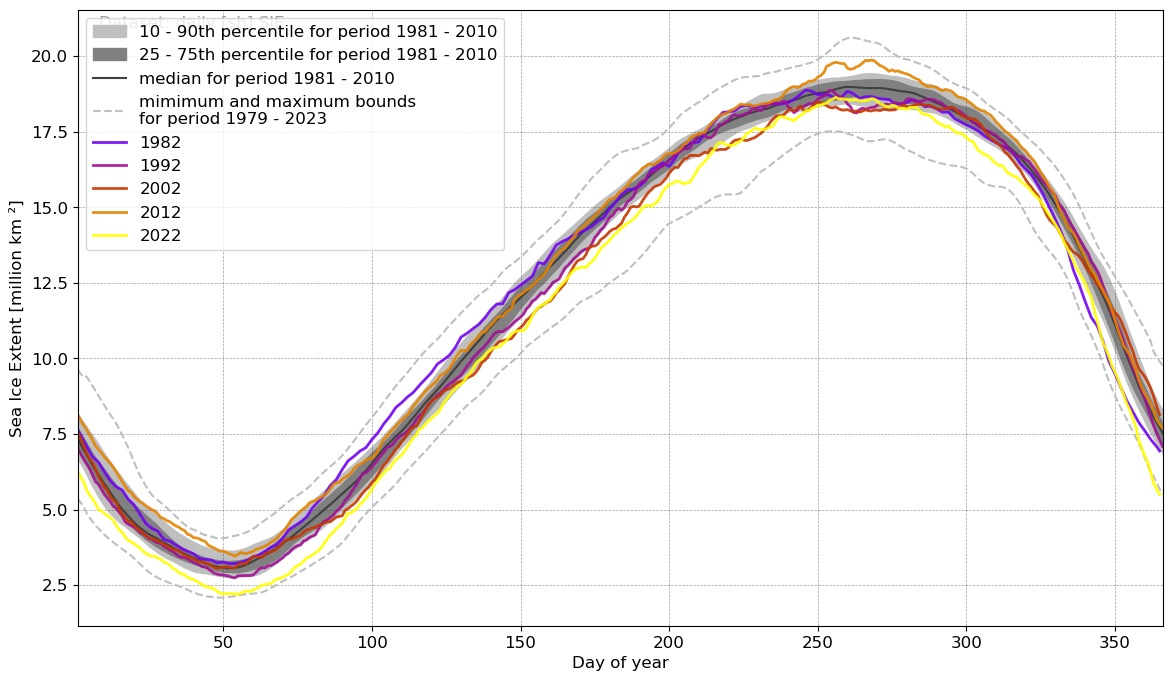

In [379]:
freq = "daily"
region = "sh"

percentiles = sie[freq][region]["percentiles"]

years = [1982, 1992, 2002, 2012, 2022]

plt.figure(figsize=(14, 8))
cmap = plt.get_cmap("gnuplot")

plt.fill_between(percentiles['P10'].dayofyear, percentiles['P90'].sie, 
                 percentiles['P10'].sie, color = '0.75', label = f"10 - 90th percentile for period {percentiles['ref_period']}")
plt.fill_between(percentiles['P25'].dayofyear, percentiles['P75'].sie, 
                 percentiles['P25'].sie, color = '0.5', label = f"25 - 75th percentile for period {percentiles['ref_period']}")
plt.plot(percentiles['P50'].dayofyear, percentiles['P50'].sie, c = "0.25", label = f"median for period {percentiles['ref_period']}")

plt.plot(percentiles['P0'].dayofyear, percentiles['P0'].sie, 
         c = "0.75", linestyle='--', label = "mimimum and maximum bounds \n" + f"for period {percentiles['total_period']}")
plt.plot(percentiles['P100'].dayofyear, percentiles['P100'].sie, c = "0.75", linestyle = '--')

for year, i in zip(years, range(1,len(years)+1)):
    TS = sie[freq][region]["dataset"].sel(time = slice(f'{year}-01-01', f'{year}-12-31'))
    label = f"{year}"
    plt.plot(TS.time.dt.dayofyear, TS.sie, c = cmap(i/len(years)), linewidth = 2, label = label, alpha = 0.9)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(ncol = 1)
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.xlabel("Day of year")
plt.xlim(1, 366)
plt.show()

We see that for large parts of 1982, the sea ice index was the highest on record. Conversely for 2012, the sea ice index was the lowest on record between days 220 and 280, which corresponds to the period between early August and early October.

The previous plot indicates that there may be a downwards trend in Arctic sea ice extent. To analyse this further, the following cell overlays data for all years onto our percentiles plot.

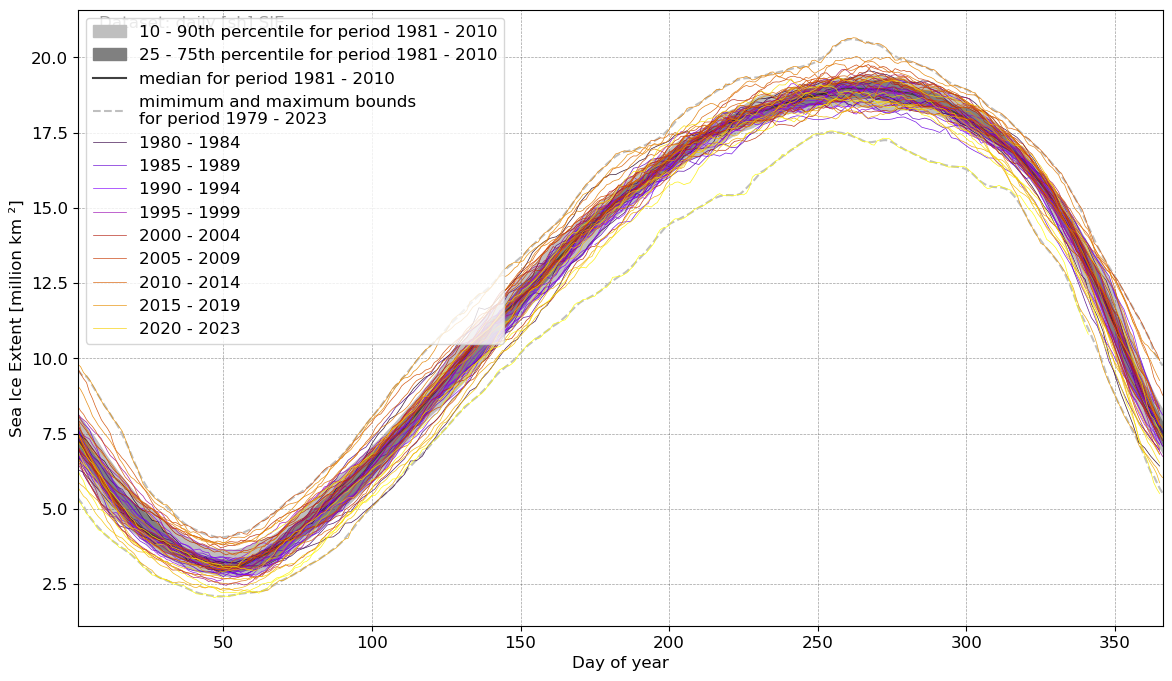

In [380]:
freq = "daily"
region = "sh"

percentiles = sie[freq][region]["percentiles"]

years = list(range(start_year, end_year + 1))

display_percentiles = True

plt.figure(figsize=(14, 8))
cmap = plt.get_cmap("gnuplot")

if display_percentiles:
    plt.fill_between(percentiles['P10'].dayofyear, percentiles['P90'].sie, 
                    percentiles['P10'].sie, color = '0.75', label = f"10 - 90th percentile for period {percentiles['ref_period']}")
    plt.fill_between(percentiles['P25'].dayofyear, percentiles['P75'].sie, 
                    percentiles['P25'].sie, color = '0.5', label = f"25 - 75th percentile for period {percentiles['ref_period']}")
    plt.plot(percentiles['P50'].dayofyear, percentiles['P50'].sie, c = "0.25", label = f"median for period {percentiles['ref_period']}")

    plt.plot(percentiles['P0'].dayofyear, percentiles['P0'].sie, 
            c = "0.75", linestyle='--', label = "mimimum and maximum bounds \n" + f"for period {percentiles['total_period']}")
    plt.plot(percentiles['P100'].dayofyear, percentiles['P100'].sie, c = "0.75", linestyle = '--')

for year, i in zip(years, range(1,len(years)+1)):
    TS = sie[freq][region]["dataset"].sel(time = slice(f'{year}-01-01', f'{year}-12-31'))
    label = None
    if year % 5 == 0:
        label = f"{max(start_year,year)} - {min(year + 4,end_year)}"
    plt.plot(TS.time.dt.dayofyear, TS.sie, c = cmap(i/len(years)), linewidth = 0.5, label = label, alpha = 0.9)

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(ncol = 1)
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.xlabel("Day of year")
plt.xlim(1, 366)
plt.show()

To aid clarity, the parameter `display_percentiles` can be set to `False` to just visualise the annual data.

Using the above plot, we observe two things:
* There does appear to be a downwards trend in sea ice extent over the years in the Arctic region.
* The range of the data appears to be larger around the seasonal minimum (September) than other times of the year. This suggests that trends in sea ice extent could be different depending on the time of year.

In the next lesson, we will analyse in more detail the monthly trends of sea ice extent. To finalise the annual analysis, the following cell performs and plots a linear regression on the time series data.

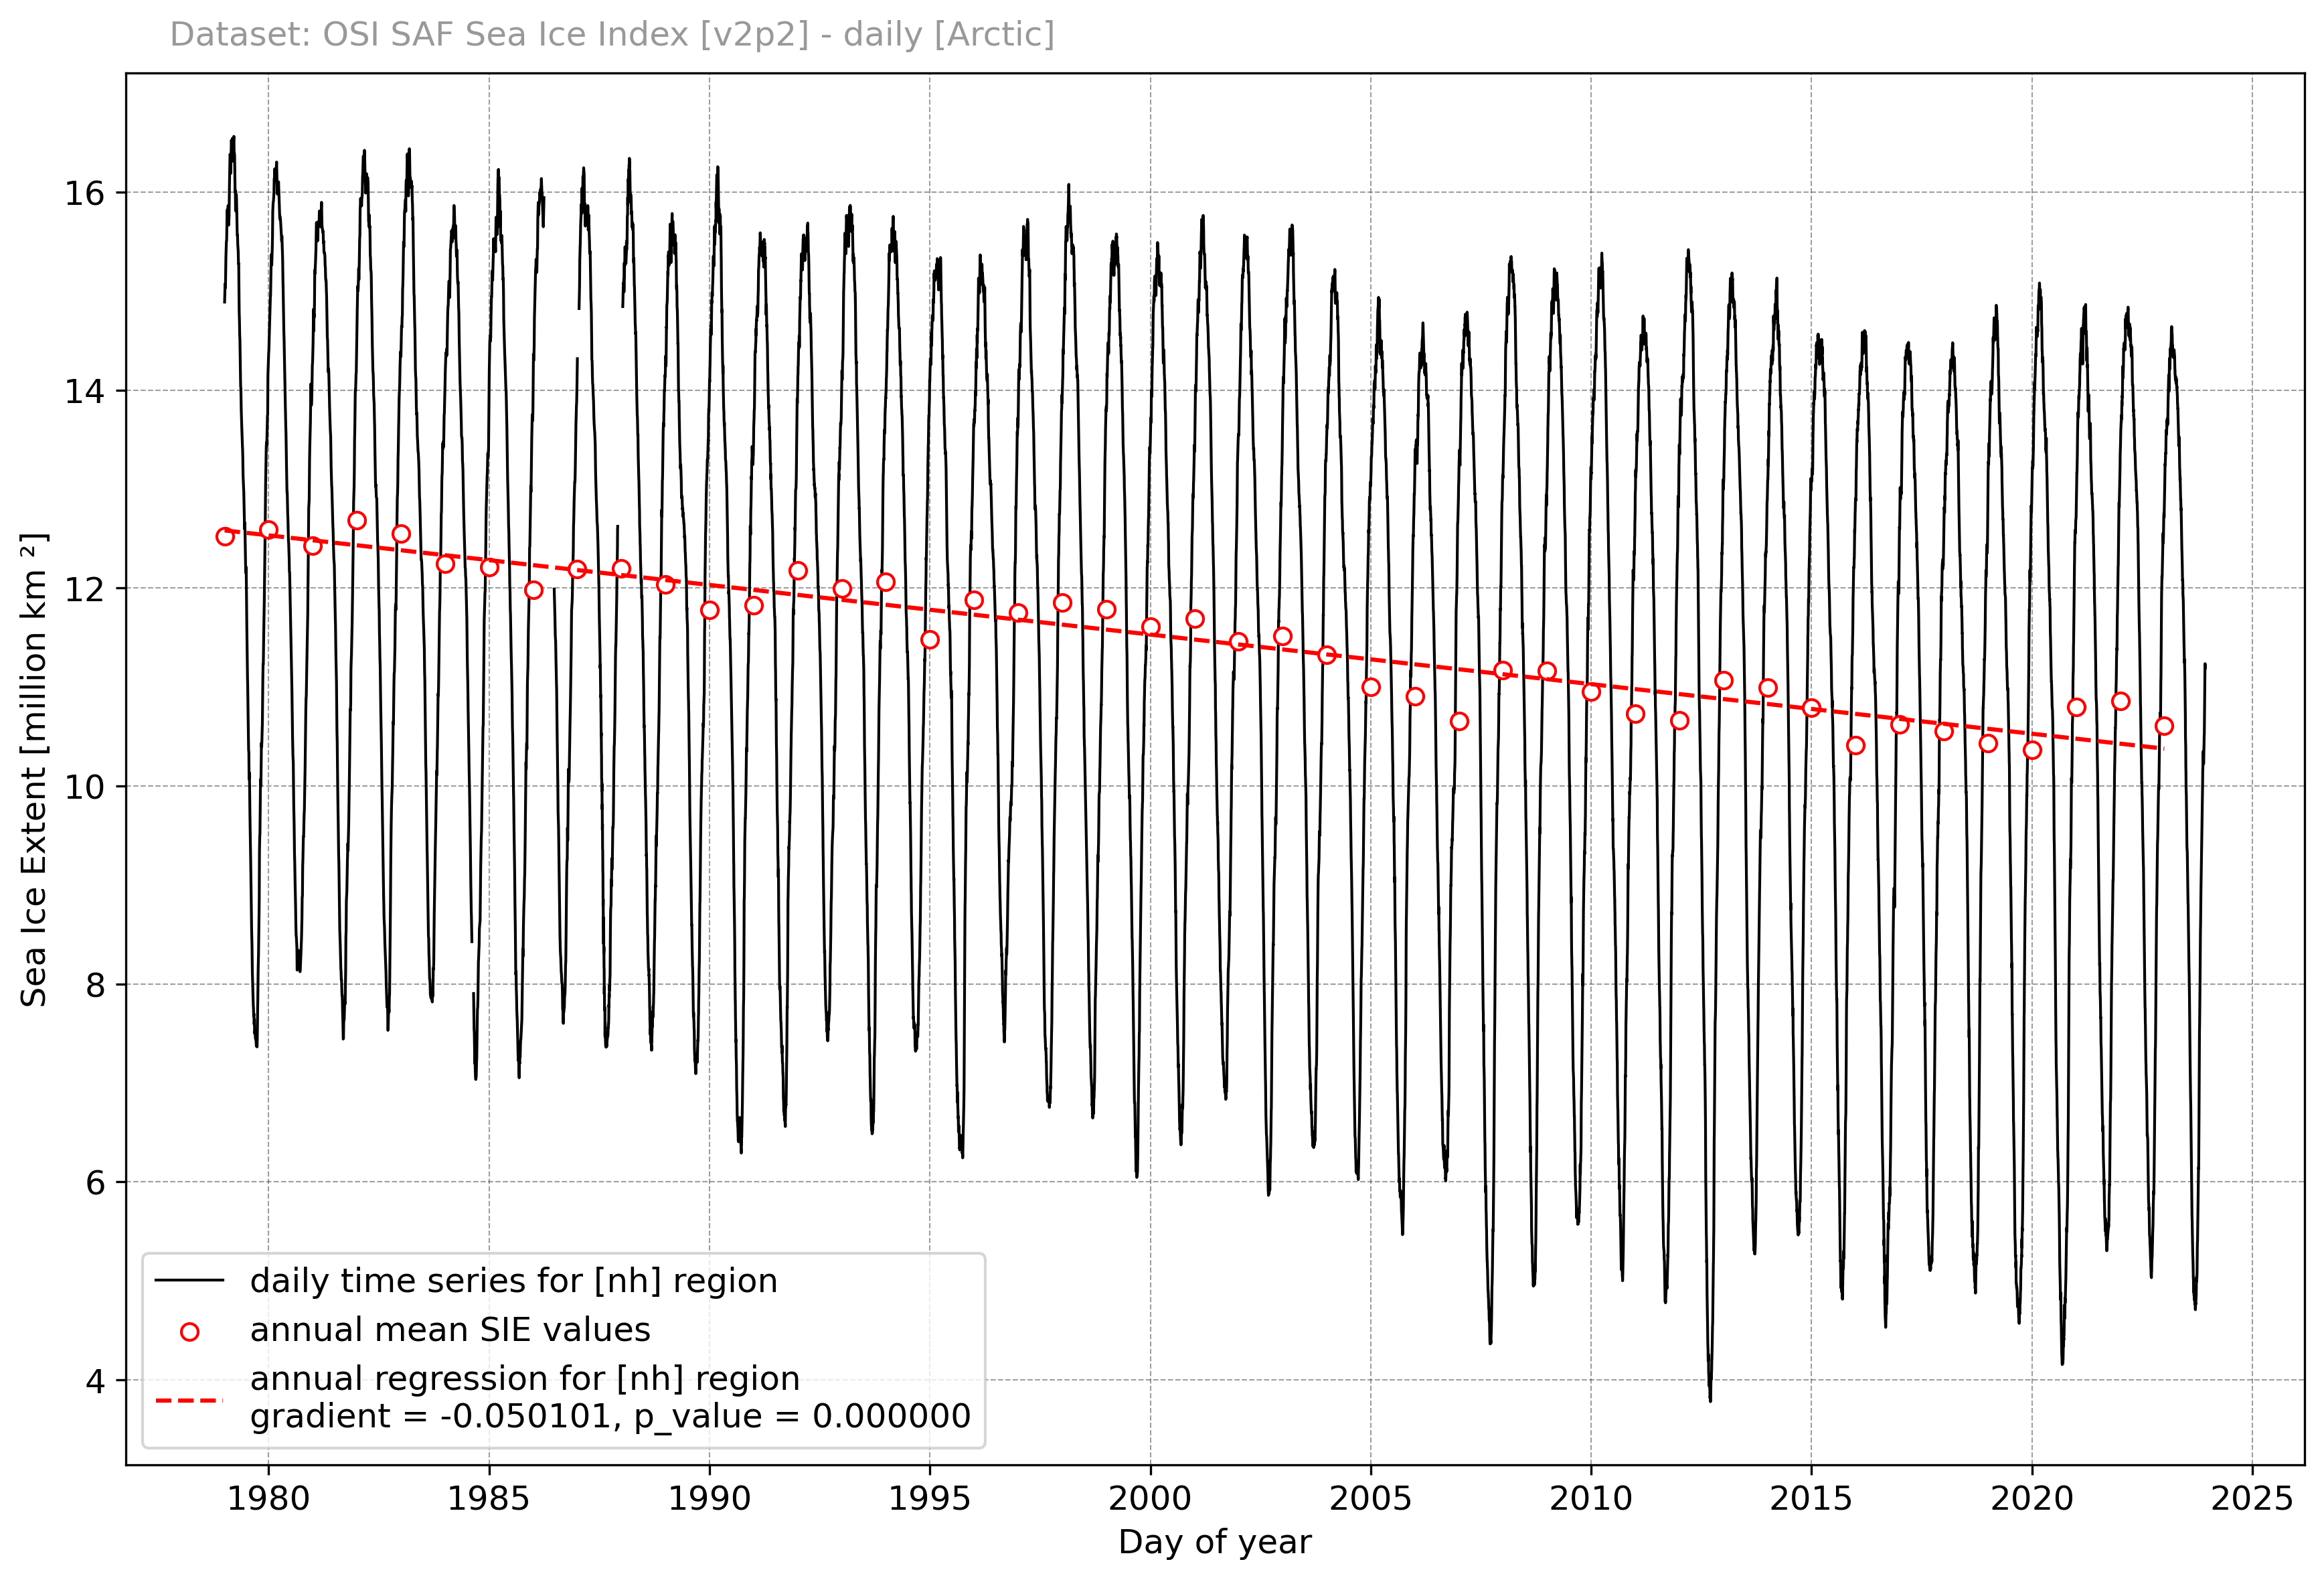

In [752]:
freq = "daily"
region = "nh"

plot_start_year = start_year
plot_end_year = end_year

working_dict = sie[freq][region]
DS = working_dict["dataset"].sel(time = slice(f'{plot_start_year}-01-01', f'{plot_end_year}-12-31'))

fig = plt.figure(figsize=(14, 9), dpi=300)
plt.rc('font', size = 12)

plt.plot(DS.time, DS.sie, linewidth=1, c="k", label = f"{freq} time series for [{region}] region")

annual = DS.groupby('time.year').mean(dim = 'time')
res = stats.linregress(annual.year, annual.sie)
years = np.array([np.datetime64(str(x)) for x in annual.year.values])

plt.scatter(years, annual.sie, c = 'white', edgecolors = 'r', zorder = 2, label = "annual mean SIE values")
plt.plot(years, res.intercept + res.slope * annual.year.values, linestyle = "--", c = "r", 
         label = f"annual regression for [{region}] region \n" + f"gradient = {res.slope:.6f}, p_value = {res.pvalue**2:.6f}" )

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)

plt.legend()

plt.xlabel("Day of year")
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords="axes fraction", color='0.6')

plt.show()

This confirms that there has indeed been a steady downward trend in Arctic sea ice extent over the range of the dataset, at a rate of approximately 50,000 square kilometers per year.

#### Lesson 3: Computing and analysing monthly trends

In the previous lesson, we observed that not only is the trend in total sea ice extent something to analyse, but it is also interesting to analyse trends for a given month over the years.

To perform these analyses, we will switch to the monthly dataset, which has an average value for SIE recorded once per month (stored on the 16th of the month). Working with monthly data like this is another way to remove noise and short-term fluctuations from a study.



Recall that the monthly SIE data is stored in subdictionaries of `sie["monthly"]`. We'll start by focusing on the Arctic `"nh"` region, and group the monthly frequency data by month.

In [754]:
freq = "monthly"
region = "nh"

months = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', 
          '05': 'May', '06': 'June', '07': 'July', '08': 'August', 
          '09': 'September', '10': 'October', '11': 'November', '12': 'December'}

DS = sie[freq][region]["dataset"]
data_start = sie[freq][region]["start_year"]
data_end = sie[freq][region]["end_year"]

sie[freq][region]["by month"] = {}
working_dict = sie[freq][region]["by month"] 

# Select monthly data, and exclude times where data was not recorded.

DS_grouped = DS.groupby('time.month')

for i, month in enumerate(months.keys()):
    working_dict[f'{month}'] = {}
    working_dict[f'{month}']["dataset"] = DS_grouped[i+1].dropna(dim = 'time')

The following cell then computes a linear regression model for each month.

In [755]:
working_dict = sie[freq][region]["by month"] 

for month in months.keys():
    DS = working_dict[month]["dataset"]
    working_dict[month]["res"] = stats.linregress(DS.time.dt.year, DS.sie.values)

The following cell plots the data and regression line for each month for the Arctic sea ice extent data.

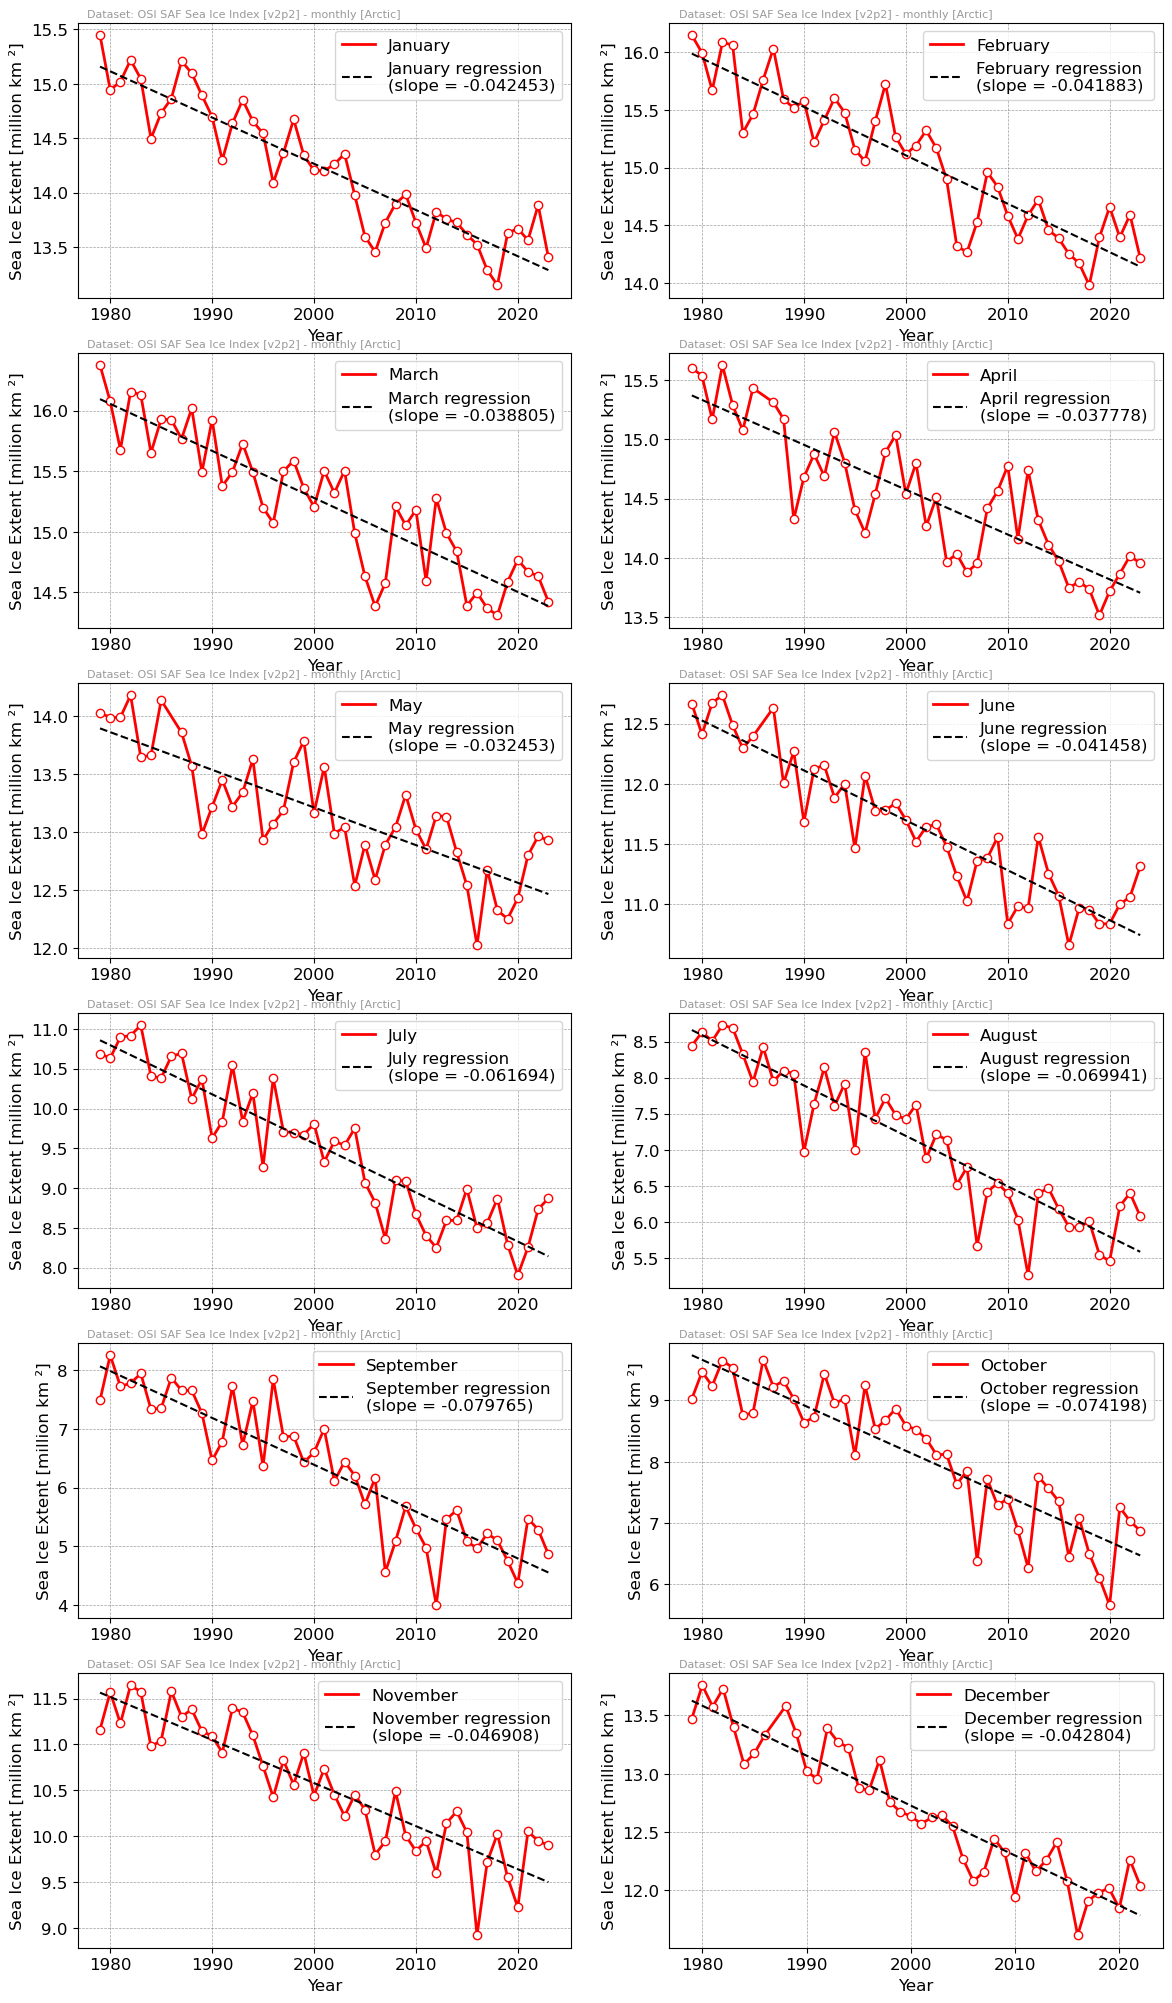

In [761]:
freq = "monthly"
region = "nh"

gs = gridspec.GridSpec(6,2)
plt.figure(figsize=(14,25))
for month in months.keys():
    working_dict = sie[freq][region]["by month"][month]
    DS = working_dict["dataset"]
    res = working_dict["res"]

    axes = plt.subplot(gs[(int(month)-1) // 2, (int(month)-1) % 2])

    axes.plot(DS.time.dt.year, DS.sie, linewidth = 2, c = "r", label = months[month])
    axes.scatter(DS.time.dt.year, DS.sie, c = 'white', edgecolors = 'r', zorder = 2)
    axes.plot(DS.time.dt.year, res.intercept + res.slope * DS.time.dt.year, linestyle = "--", c = "k", 
              label = f'{months[month]} regression \n' + f'(slope = {res.slope:.6f})' )

    plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend()
    plt.ylabel("Sea Ice Extent [million km \u00b2]")
    plt.xlabel("Year")

    axes.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords = "axes fraction", color = '0.6', fontsize = 8)

plt.show()

The Arctic sea ice is at its maximum and minimum around March and September, respectively. The following cell overlays the two regression lines for these two months onto the full monthly time series.

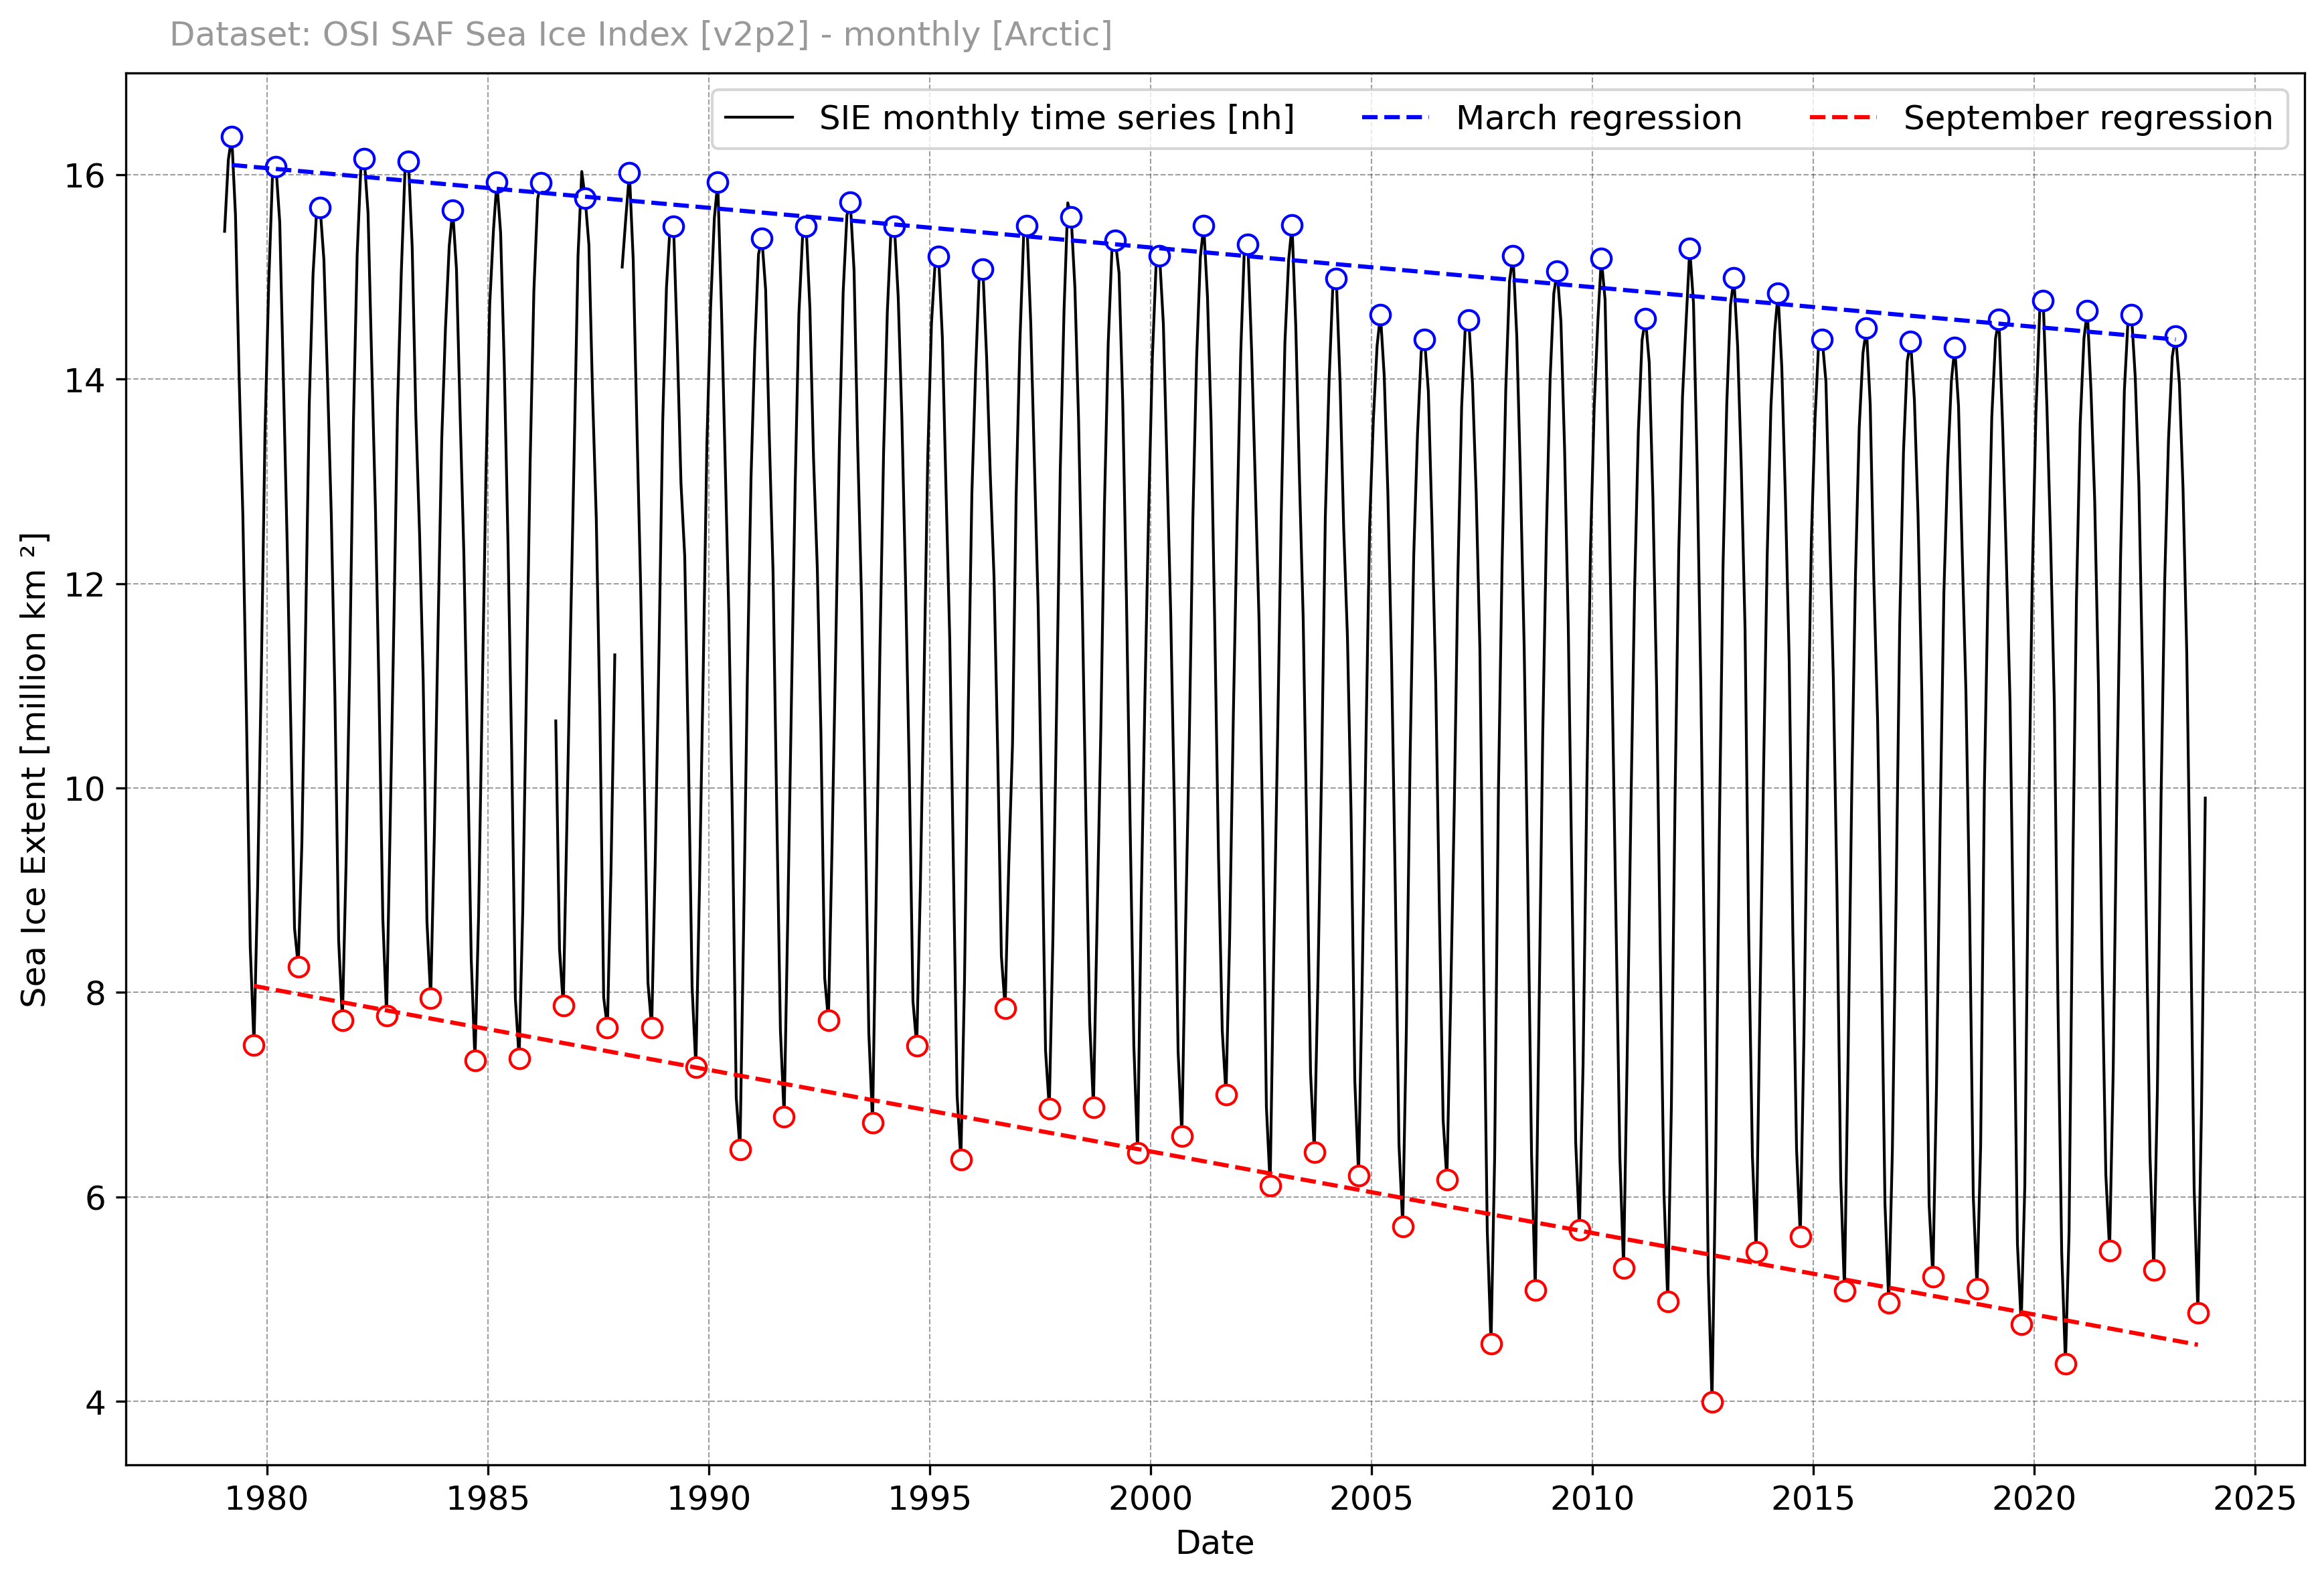

In [762]:
freq = "monthly"
region = "nh"

working_dict = sie[freq][region]

DS = working_dict["dataset"]

plt.figure(figsize=(14,9), dpi = 300)

plt.plot(DS.time, DS.sie, c = "k", label = f"SIE {freq} time series [{region}]", linewidth = 1)
plt.ylabel("Sea Ice Index")

for month, col in zip(["03", "09"], ["b", "r"]):
    month_data = working_dict["by month"][month]
    DS = month_data["dataset"]
    res = month_data["res"]
    plt.scatter(DS.time, DS.sie, c = 'white', s = 50, edgecolors = col, zorder = 2)
    plt.plot(DS.time, res.intercept + res.slope * DS.time.dt.year, linestyle = "--", c = col, label = f'{months[month]} regression' )

plt.grid(color='0.25', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(ncol = 3)
plt.ylabel("Sea Ice Extent [million km \u00b2]")
plt.xlabel("Date")

plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, 1.02), xycoords = "axes fraction", color = '0.6')

plt.show()


This plot gives a clear visualisation of the difference in rates for which the Arctic sea ice has changed at its maximum and minimum points. In particular, we observe that the downward trend is greater for the minimum points, and less for the maximum points.

#### Lesson 4: Ranking monthly sea ice extent data

In this lesson we will explore a method to visualise trends in monthly sea ice data by producing rank plots.

We begin by computing and storing the rank of the monthly data. For the time series `TS` of sea ice extent data grouped by a given month, the function `stats.rankdata(TS)` outputs an array storing the ranks of each data point in `TS`.

The following cell computes the rank data for each month, and creates a 2-dimensional array storing all the data, which is stored in a subdictionary `"rank_matrix"`.

In [771]:
freq = "monthly"
region = "nh"

# Access the working dictionary and store its start and end years

working_dict = sie[freq][region]

start_year = working_dict["start_year"]
end_year = working_dict["end_year"]

all_years = np.arange(start_year, end_year + 1)

# Initialise a dictionary to store the monthly ranks for a given year

rank = {}
for year in all_years:
    rank[f'{year}'] = np.zeros(12)

# Compute the ranks for each month and store them in the ranks dictionary

for j, month in enumerate(months.keys()):
    DS = working_dict["by month"][month]["dataset"]
    years = DS.time.dt.year.values
    DS_ranks = stats.rankdata(DS.sie.values)
    for i, year in enumerate(years):
        rank[f'{year}'][j] = DS_ranks[i]

# Generate a 2-dimensional array from the ranks dictionary data and store it in the working dictionary.

working_dict["by month"]["rank_matrix"] = np.flipud(np.array([rank[year] for year in rank.keys()], dtype = int))
    

You can get a feel of the rank data by running the following cell.

In [772]:
sie["monthly"]["nh"]["by month"]["rank_matrix"]

array([[ 3,  3,  5,  9, 14, 15, 15,  9,  5,  7,  8,  0],
       [17, 15, 11, 12, 16, 11, 12, 14, 12,  9, 10,  7],
       [ 7, 10, 12,  6,  9,  9,  3, 11, 15, 11, 15, 13],
       [11, 16, 13,  2,  4,  4,  1,  2,  2,  1,  2,  2],
       [10,  9,  8,  1,  2,  2,  4,  3,  4,  2,  3,  6],
       [ 1,  1,  1,  3,  3,  5, 14,  7, 10,  6, 13,  5],
       [ 2,  2,  2,  5,  8,  7,  8,  5, 11, 10,  5,  3],
       [ 6,  4,  6,  4,  1,  1,  7,  6,  6,  5,  1,  1],
       [ 9,  8,  4, 11,  6, 12, 16, 10,  8, 13, 14,  8],
       [14, 11, 14, 14, 10, 14,  9, 16, 16, 15, 18, 17],
       [15, 17, 16, 18, 23, 22, 10, 13, 14, 18, 16, 12],
       [16, 14, 23, 28, 24,  6,  2,  1,  1,  3,  4, 11],
       [ 5,  7,  9, 15, 11,  8,  6,  8,  7,  8, 11, 15],
       [12, 13, 19, 29, 19,  3, 11, 12, 13, 14,  7,  4],
       [20, 18, 17, 25, 29, 21, 18, 18, 17, 12, 12, 16],
       [18, 20, 22, 21, 20, 17, 19, 15,  9, 17, 24, 18],
       [13, 12,  7,  8, 12, 16,  5,  4,  3,  4,  9, 10],
       [ 4,  5,  3,  7,  7, 10,

Data across each row is the rank of each month for a fixed year, from January to December. Data down each column is the rank of a fixed month for each year. The first year in the array is the most recent year. An entry of 0 indicates that no data was recorded for that month in that year.

The following cell plots the data in the rank matrix, overlaid on a 2-dimensional mesh plot coloured according to the rank data.

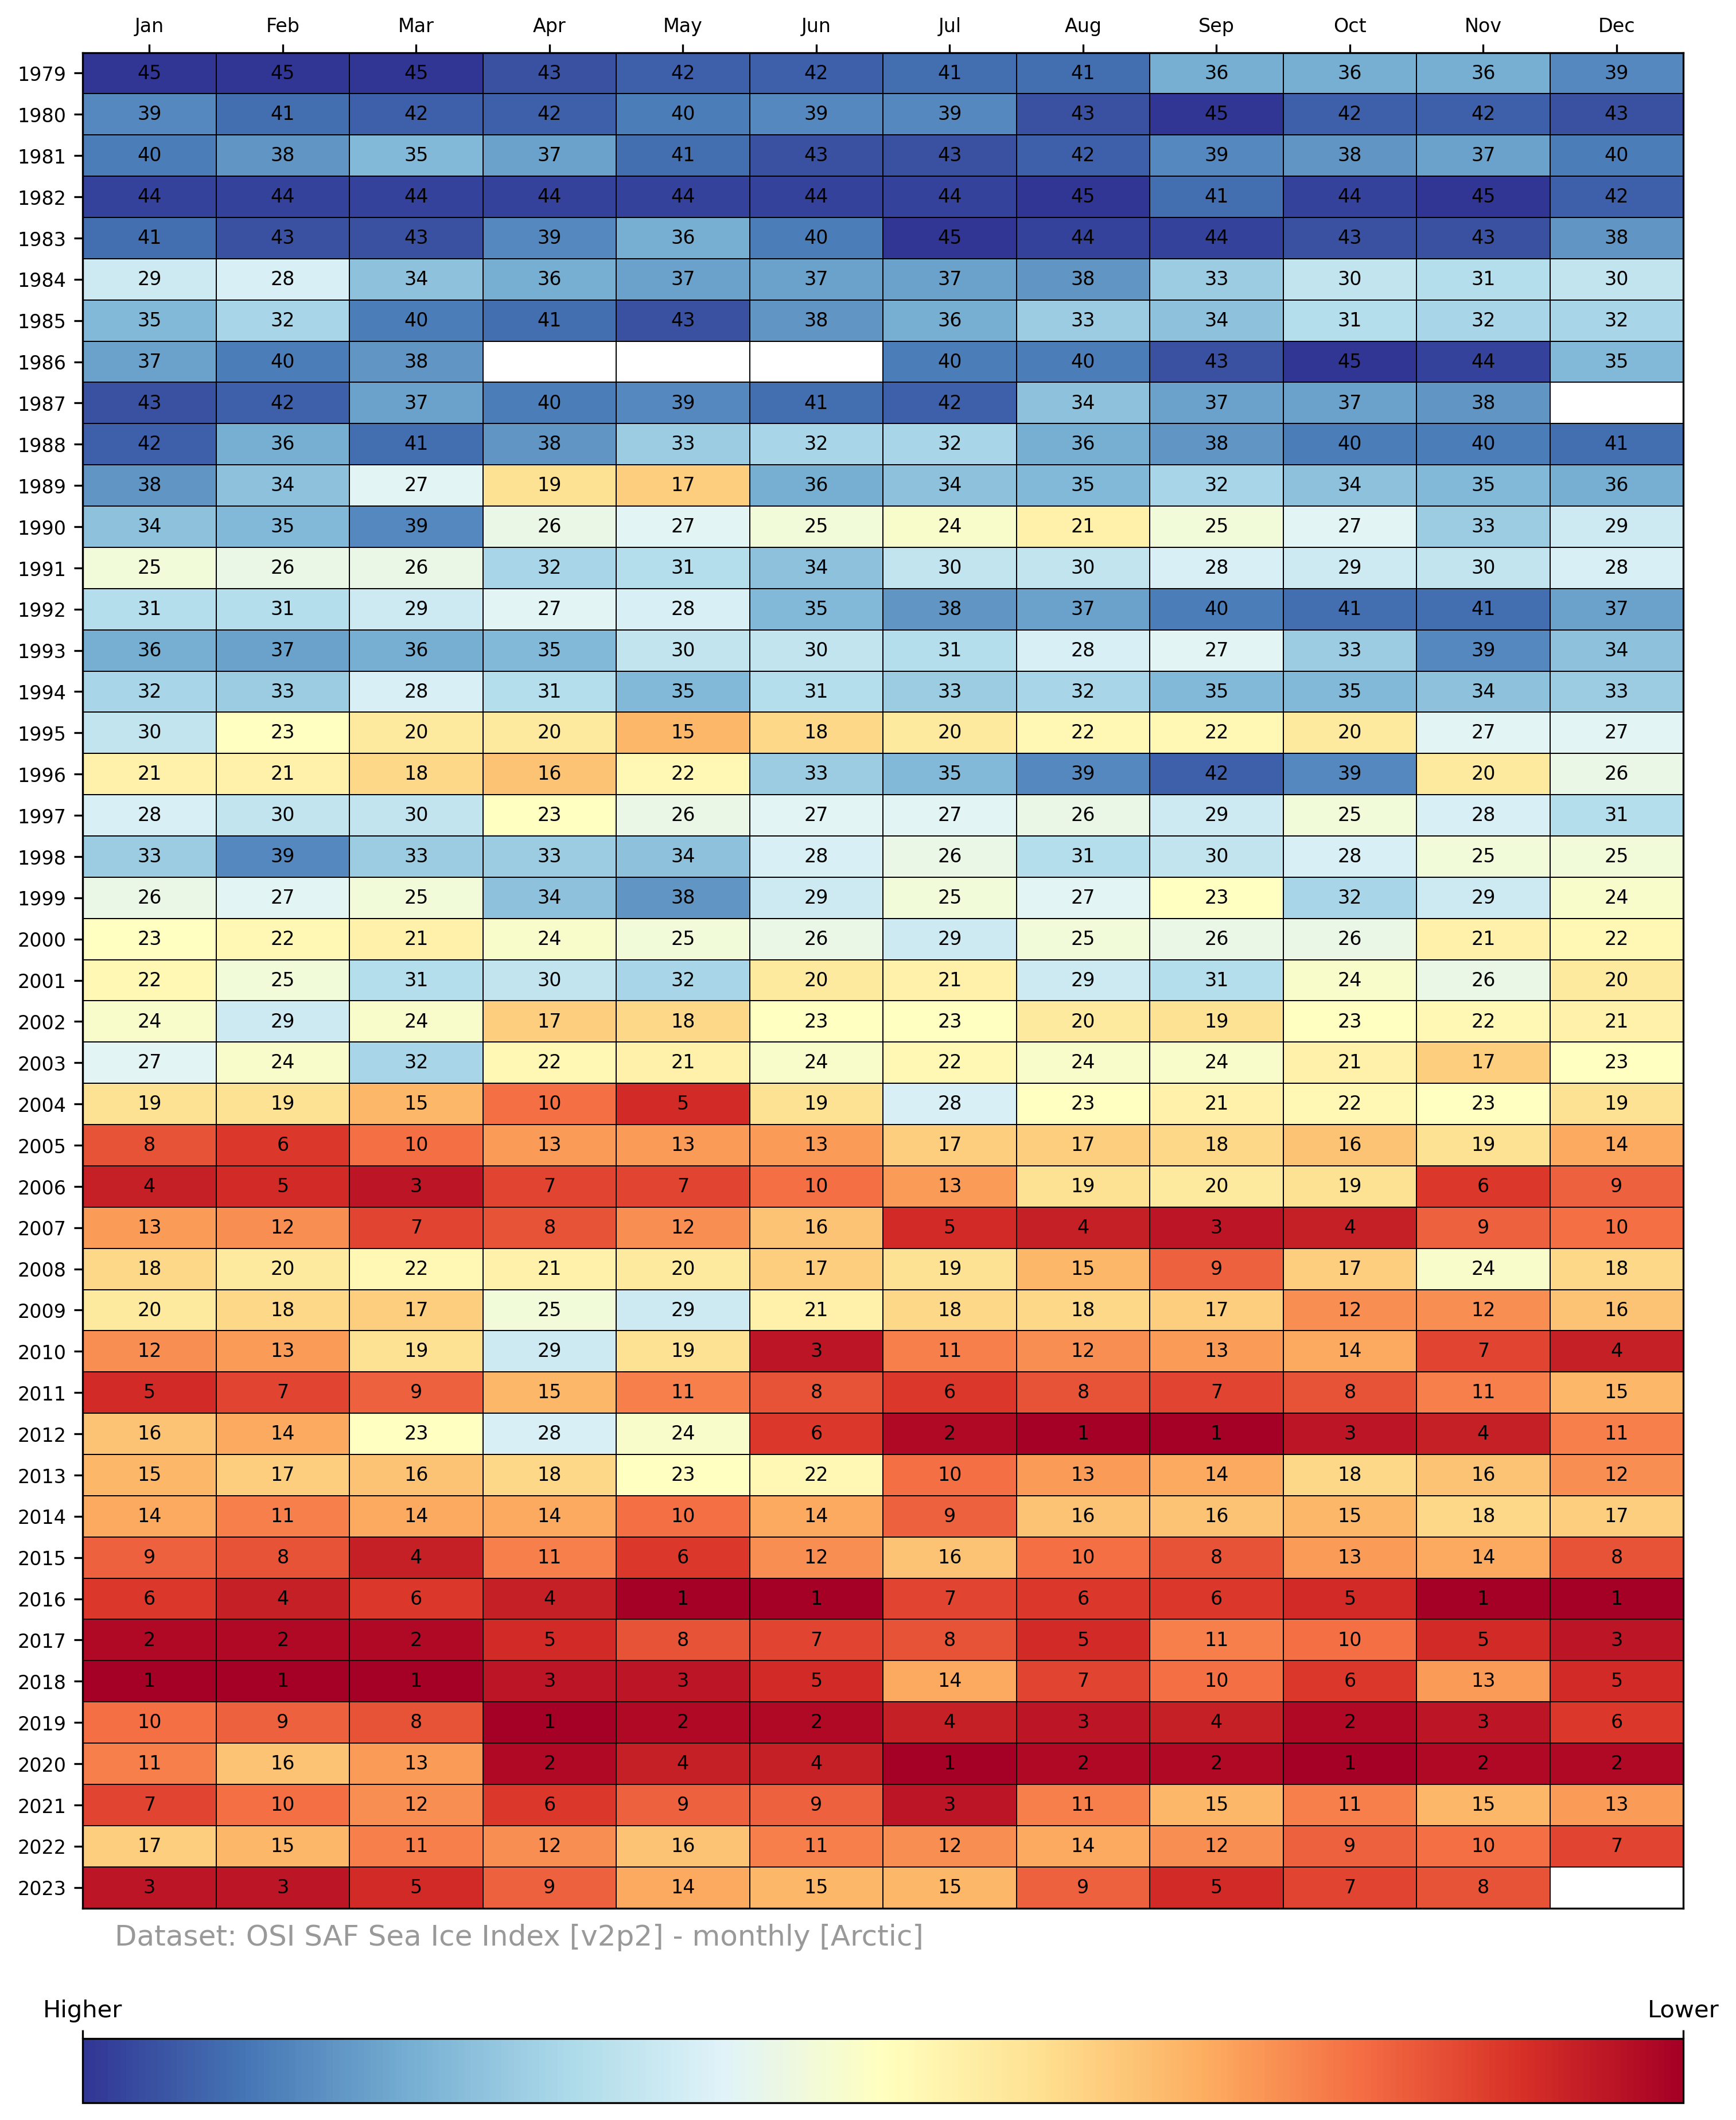

In [774]:
freq = "monthly"
region = "nh"

rank_matrix = sie[freq][region]["by month"]["rank_matrix"]

# Set up the figure and axes to plot on

plt.figure(figsize=(12, 20), dpi = 300)
ax = plt.subplot()

# Define the colour map used for the plot, and plot a pcolormesh object according to the rank data

cmap = plt.get_cmap("RdYlBu")
cmap.set_under("white")

cm = ax.pcolormesh(rank_matrix, edgecolor = "k", 
                   linewidth = 0.1, cmap = cmap, vmax = len(all_years), vmin = 1, norm = "linear")

# Customise the axes labels and colour bar legend

ax.set_yticks(ticks = np.arange(0.5,len(all_years) + 0.5), labels = np.flipud(all_years), fontsize = 8)
ax.set_xticks(ticks = np.arange(0.5,12.5), labels = [mon[:3] for mon in months.values()], fontsize = 8)
ax.xaxis.set_ticks_position('top')

cbar = plt.colorbar(cm, orientation = "horizontal", ax = ax, use_gridspec = True, aspect = 25, anchor = (0.5,1.8))

cbar.ax.invert_xaxis()
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks(ticks = [1, len(all_years)], labels = ["Lower", "Higher"], fontsize = 10)

# Write the rank data on top of the pcolormesh plot

[ax.text(j + 0.5, i + 0.5, (None if (x := rank_matrix[i,j]) == 0 else f"{x}"), 
         fontsize = 8, ha = "center", va = "center") for i in range(45) for j in range(12)]

plt.annotate(f"Dataset: {data_name} - {freq} [{regions[region]}]", (0.02, -0.02), xycoords = "axes fraction", color = '0.6')

plt.show()

